In [194]:
import tensorflow as tf
#import wave
import glob
import scipy.io.wavfile as wavfile
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [195]:
global SMP_RATE
SMP_RATE = 16000

In [196]:
def getWaveName(wavepath):
    return wavepath.split('/')[-1]

def findWave(wavefile,path):
    r = glob.glob(path+wavefile)
    return r[0]

In [197]:
# fpath = '../../cmu_artic/female_us_slt/' #desktop
# mpath = '../../cmu_artic/male_us_bdl/' #desktop
fpath = '../data/female_us/'
mpath = '../data/male_us/'

# Hacky parallel dataset

In [198]:
# map male to female
m2f = dict()
for i in glob.glob(mpath+'/*.wav'):
    m2f[i]=findWave(getWaveName(i),fpath)

In [199]:
m2f.keys()[0]

'../data/male_us/arctic_a0058.wav'

# Bin before hand

In [200]:
bin_size_x = (2,3)
bin_size_y = (2,3)

In [201]:
bin_mapping = {}
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    size = wav_data.shape[0]/(1.0*fm)
    if size < bin_size_x[1] and size > bin_size_x[0]:
        fm2, wav_data2 = wavfile.read(m2f[filename])
        size2 = wav_data2.shape[0]/(1.0*fm2)
        if size2 < bin_size_x[1] and size2 > bin_size_x[0]:
            bin_mapping[filename] = m2f[filename]

In [202]:
len(bin_mapping)

348

# Sec to Samples

In [203]:
def sec2samp(sec,smp_rate):
    return int(sec*smp_rate)

# Padding

In [204]:
def padTo(x,size,kind='SYM'):
    """
    Expects 1D array
    """
    assert kind in ['LEFT','RIGHT','SYM']
    if kind == 'LEFT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((pad,x),axis=0)
    elif kind == 'RIGHT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((x,pad),axis=0)
    elif kind == 'SYM':
        padl = np.zeros((size-len(x))/2,dtype=x.dtype)
        padr = np.zeros((size-len(x))/2+(size-len(x))%2,dtype=x.dtype)
        r = np.concatenate((padl,x,padr),axis=0)
    return r

# Batch Generator

convolution expects data of shape (batchsize,height,width,inchannel)

Data should be of shape (batchsize,height=1,time_length (this is width),inchannel=1)

In [205]:
class Batch(object):
    def __init__(self,mapping,bin_max,batch_size=1):
        self.mapping = mapping
        self.bin_max = bin_max
        self.batch_size = batch_size
        self.seq_size = self.bin_max*SMP_RATE
        self.shape = (self.batch_size,1,self.seq_size,1)
        self.x_list = mapping.keys()
        self.size = len(self.x_list) #data size
        self.cursors = [(self.size//self.batch_size)*i for i in range(self.batch_size)]
        
    def getBatch(self):
        #get the file names
        x_path = [self.x_list[c] for c in self.cursors]
        y_path = [self.mapping[xp] for xp in x_path]
        
        #Get the x,y files and pad
        x = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        y = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        for i,(xp,yp) in enumerate(zip(x_path,y_path)):
            _,x_raw=wavfile.read(xp)
            _,y_raw=wavfile.read(yp)
            x_pad = padTo(x_raw,self.bin_max*SMP_RATE)
            y_pad = padTo(y_raw,self.bin_max*SMP_RATE)
            x[i,0,:,0]=x_pad
            y[i,0,:,0]=y_pad
            
        #update cursor positions
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return (x,y)

In [206]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=3)

# PReLU

In [226]:
def prelu(x,name='prelu'):
    in_shape = x.get_shape().as_list()
    with tf.variable_scope(name):
        alpha = tf.get_variable('alpha',in_shape[-1],
                               initializer=tf.constant_initializer(0.),
                               dtype=tf.float32)
        pos = tf.nn.relu(x)
        neg = alpha * (x-tf.abs(x))*.5
        
        return pos + neg

# Build Graph and give inputs

In [307]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=32)

In [308]:
g = tf.Graph()
with g.as_default():
    #try None shapes
    x = tf.placeholder(tf.float32,shape=b.shape)
    y = tf.placeholder(tf.float32,shape=b.shape)

# Generator

In [309]:
with g.as_default():
    def Gen(x,reuse=False):
        with tf.variable_scope('Generator') as scope:
            if reuse:
                scope.reuse_variables()
            #Down Colnvolutions
            #create variables
            with tf.variable_scope('in'):
                # Shape (height,width,inchannels,out_channels)
                conv1=tf.get_variable('conv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.01))
                conv2=tf.get_variable('conv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.01))
                conv3=tf.get_variable('conv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.01))
                conv4=tf.get_variable('conv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.01))
                conv5=tf.get_variable('conv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.01))
                conv6=tf.get_variable('conv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.01))
                conv7=tf.get_variable('conv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.01))

                b1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.01))
                b2 = tf.get_variable('b2',shape=16,initializer=tf.constant_initializer(0.01))
                b3 = tf.get_variable('b3',shape=32,initializer=tf.constant_initializer(0.01))
                b4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.01))
                b5 = tf.get_variable('b5',shape=64,initializer=tf.constant_initializer(0.01))
                b6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.01))
                b7 = tf.get_variable('b7',shape=128,initializer=tf.constant_initializer(0.01))

            #down convolutions operations
            with tf.variable_scope('l1'):
                l1=prelu(tf.nn.conv2d(x,conv1,strides=[1,1,2,1],padding='SAME')+b1)
            with tf.variable_scope('l2'):
                l2=prelu(tf.nn.conv2d(l1,conv2,strides=[1,1,2,1],padding='SAME')+b2)
            with tf.variable_scope('l3'):
                l3=prelu(tf.nn.conv2d(l2,conv3,strides=[1,1,2,1],padding='SAME')+b3)
            with tf.variable_scope('l4'):
                l4=prelu(tf.nn.conv2d(l3,conv4,strides=[1,1,2,1],padding='SAME')+b4)
            with tf.variable_scope('l5'):
                l5=prelu(tf.nn.conv2d(l4,conv5,strides=[1,1,2,1],padding='SAME')+b5)
            with tf.variable_scope('l6'):
                l6=prelu(tf.nn.conv2d(l5,conv6,strides=[1,1,2,1],padding='SAME')+b6)
            with tf.variable_scope('l7'):
                l7=prelu(tf.nn.conv2d(l6,conv7,strides=[1,1,2,1],padding='SAME')+b7)


            last_shape = l7.get_shape()
            es=int(last_shape[2]) #encoding size

            # Transpose Convolution
            #Create variables
            with tf.variable_scope('out'):
                # Shape (height,width,out_channels,input channels)
                dconv7 = tf.get_variable('dconv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.01))
                dconv6 = tf.get_variable('dconv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.01))
                dconv5 = tf.get_variable('dconv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.01))
                dconv4 = tf.get_variable('dconv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.01))
                dconv3 = tf.get_variable('dconv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.01))
                dconv2 = tf.get_variable('dconv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.01))
                dconv1 = tf.get_variable('dconv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.01))

                db7 = tf.get_variable('b7',shape=64,initializer=tf.constant_initializer(0.01))
                db6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.01))
                db5 = tf.get_variable('b5',shape=32,initializer=tf.constant_initializer(0.01))
                db4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.01))
                db3 = tf.get_variable('b3',shape=16,initializer=tf.constant_initializer(0.01))
                db2 = tf.get_variable('b2',shape=1,initializer=tf.constant_initializer(0.01))
                db1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.01))

                with tf.variable_scope('dl7'):
                    dl7 = prelu(tf.nn.conv2d_transpose(l7,dconv7,output_shape=[b.batch_size,1,(2**1)*es,64],strides=[1,1,2,1])+db7)+l6
                with tf.variable_scope('dl6'):
                    dl6 = prelu(tf.nn.conv2d_transpose(dl7,dconv6,output_shape=[b.batch_size,1,(2**2)*es,64],strides=[1,1,2,1])+db6)+l5
                with tf.variable_scope('dl5'):
                    dl5 = prelu(tf.nn.conv2d_transpose(dl6,dconv5,output_shape=[b.batch_size,1,(2**3)*es,32],strides=[1,1,2,1])+db5)+l4
                with tf.variable_scope('dl4'):
                    dl4 = prelu(tf.nn.conv2d_transpose(dl5,dconv4,output_shape=[b.batch_size,1,(2**4)*es,32],strides=[1,1,2,1])+db4)+l3
                with tf.variable_scope('dl3'):
                    dl3 = prelu(tf.nn.conv2d_transpose(dl4,dconv3,output_shape=[b.batch_size,1,(2**5)*es,16],strides=[1,1,2,1])+db3)+l2
                with tf.variable_scope('dl2'):
                    dl2 = prelu(tf.nn.conv2d_transpose(dl3,dconv2,output_shape=[b.batch_size,1,(2**6)*es,1],strides=[1,1,2,1])+db2)+l1
                with tf.variable_scope('dl1'):
                    dl1 = prelu(tf.nn.conv2d_transpose(dl2,dconv1,output_shape=[b.batch_size,1,(2**7)*es,1],strides=[1,1,2,1])+db1)+x
        return dl1
    

# Discriminator

In [310]:
with g.as_default():
    def Dis(x,reuse=False):
        with tf.variable_scope('Discriminator') as scope:
            if reuse:
                scope.reuse_variables()
            #Down Colnvolutions
            #create variables
            with tf.variable_scope('in'):
                # Shape (height,width,inchannels,out_channels)
                dis_conv1=tf.get_variable('conv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv2=tf.get_variable('conv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv3=tf.get_variable('conv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv4=tf.get_variable('conv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv5=tf.get_variable('conv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv6=tf.get_variable('conv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv7=tf.get_variable('conv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.1))

                dis_b1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.1))
                dis_b2 = tf.get_variable('b2',shape=16,initializer=tf.constant_initializer(0.1))
                dis_b3 = tf.get_variable('b3',shape=32,initializer=tf.constant_initializer(0.1))
                dis_b4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.1))
                dis_b5 = tf.get_variable('b5',shape=64,initializer=tf.constant_initializer(0.1))
                dis_b6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.1))
                dis_b7 = tf.get_variable('b7',shape=128,initializer=tf.constant_initializer(0.1))

            #down convolutions operations
            with tf.variable_scope('l1'):
                dis_l1=prelu(tf.nn.conv2d(x,dis_conv1,strides=[1,1,2,1],padding='SAME')+dis_b1)
            with tf.variable_scope('l2'):
                dis_l2=prelu(tf.nn.conv2d(dis_l1,dis_conv2,strides=[1,1,2,1],padding='SAME')+dis_b2)
            with tf.variable_scope('l3'):
                dis_l3=prelu(tf.nn.conv2d(dis_l2,dis_conv3,strides=[1,1,2,1],padding='SAME')+dis_b3)
            with tf.variable_scope('l4'):
                dis_l4=prelu(tf.nn.conv2d(dis_l3,dis_conv4,strides=[1,1,2,1],padding='SAME')+dis_b4)
            with tf.variable_scope('l5'):
                dis_l5=prelu(tf.nn.conv2d(dis_l4,dis_conv5,strides=[1,1,2,1],padding='SAME')+dis_b5)
            with tf.variable_scope('l6'):
                dis_l6=prelu(tf.nn.conv2d(dis_l5,dis_conv6,strides=[1,1,2,1],padding='SAME')+dis_b6)
            with tf.variable_scope('l7'):
                dis_l7=prelu(tf.nn.conv2d(dis_l6,dis_conv7,strides=[1,1,2,1],padding='SAME')+dis_b7)

            dis_last_shape = dis_l7.get_shape()
            dis_es=int(dis_last_shape[2])*int(dis_last_shape[3]) #size of encoding
            dis_last = tf.reshape(dis_l7,[b.batch_size,dis_es])

            #fully connected
            with tf.variable_scope('fc'):
                W_fc = tf.get_variable('W',shape=[dis_es,1],initializer=tf.turncated_normal_initializer(0.1))
                b_fc = tf.get_variable('b',shape=[1],initializer=tf.constant_initializer(0.1))

            D_out = tf.sigmoid(tf.matmul(dis_last,W_fc)+b_fc)
        return D_out

# Loss functions and Optimization ops

In [311]:
eps = .01
with g.as_default():
    # loss functions
    loss_d = tf.reduce_mean(tf.square(Dis(x,reuse=False)-1))
    loss_d_g = tf.reduce_mean(tf.square(Dis(Gen(x),reuse=True)))
    loss1 = loss_d+loss_d_g
    
    loss_g = tf.reduce_mean(tf.square(1-Dis(Gen(x,reuse=True),reuse=True)))
    loss2 = loss_g

    #optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=.0002)
    
    #Variable lists
    dvars = [e for e in g.get_collection('trainable_variables') if 'Discriminator' in e.name]
    gvars = [e for e in g.get_collection('trainable_variables') if 'Generator' in e.name]
    
    opt1 = optimizer.minimize(loss1,var_list=dvars)
    opt2 = optimizer.minimize(loss2,var_list=gvars)

    #opt = tf.train.RMSPropOptimizer(learning_rate = 0.0002)

    init = tf.global_variables_initializer()

    saver = tf.train.Saver()

# Model Name

In [312]:
save_path = 'modelckpt/modelGAN.ckpt'

# Hyper parameters

In [313]:
k = 1

# Train Steps

In [314]:
dlosses = []
glosses = []
sess = tf.Session(graph=g)
sess.run(init) 
#saver.restore(sess,save_path) #comment to start training over

In [315]:
#num_steps = 5000*30*7 #big league training
num_steps = 5
save_step = 500*30
for i in tqdm(xrange(num_steps)):
    x_data,y_data = b.getBatch()
    fd = {x:x_data,y:y_data}
    _,dl = sess.run([opt1,loss1],feed_dict=fd)
    _,gl = sess.run([opt2,loss2],feed_dict=fd)
    dlosses.append(dl)
    glosses.append(gl)
    if i % save_step == 0:
        save_path = saver.save(sess, save_path)

100%|██████████| 10/10 [02:13<00:00, 12.87s/it]


In [316]:
dl

1.0

# Evaluation Loss

<function matplotlib.pyplot.show>

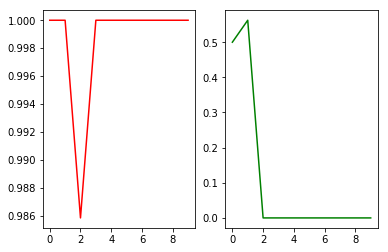

In [326]:
plt.subplot(121)
plt.plot(dlosses,color='red')
plt.subplot(122)
plt.plot(glosses,color='green')
plt.show

In [319]:
# skip_plot=50000
# plt.plot(losses[skip_plot:])

# Evaluate Data

In [321]:
with g.as_default():
    gen_audio = Gen(x,reuse=True)

In [324]:
x_data,y_data = b.getBatch() #uncomment if not training
fd = {x:x_data,y:y_data} #uncomment if not training
result = sess.run(gen_audio,feed_dict=fd)

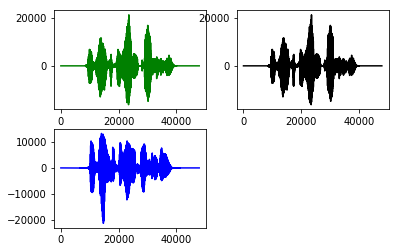

In [325]:
plt.subplot(221)
plt.plot(result[0,0,:,0],color='green')
plt.subplot(222)
plt.plot(x_data[0,0,:,0],color='black')
plt.subplot(223)
plt.plot(y_data[0,0,:,0],color='blue')

# Write to audio file

In [82]:
#generated
f = open('samples/generated_audio.wav','wr')
wavfile.write(f,SMP_RATE,result[0,0,:,0].astype(np.int16))
f.close()

In [83]:
#original
f = open('samples/org_audio.wav','wr')
wavfile.write(f,SMP_RATE,x_data[0,0,:,0].astype(np.int16))
f.close()

In [84]:
#target
f = open('samples/target_audio.wav','wr')
wavfile.write(f,SMP_RATE,y_data[0,0,:,0].astype(np.int16))
f.close()